In [30]:
#1 Aggregate the tornado data in Illinois into a monthly count of tornadoes
# Load in the Data

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, VBox, HBox, fixed, Output
from IPython.display import display, HTML
df = pd.read_csv("https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv")
print(df.head(3))

    om    yr  mo  dy        date      time  tz  st  stf  stn  ...   len  wid  \
0  192  1950  10   1  1950-10-01  21:00:00   3  OK   40   23  ...  15.8   10   
1  193  1950  10   9  1950-10-09  02:15:00   3  NC   37    9  ...   2.0  880   
2  195  1950  11  20  1950-11-20  02:20:00   3  KY   21    1  ...   0.1   10   

   ns  sn  sg   f1  f2  f3  f4  fc  
0   1   1   1   25   0   0   0   0  
1   1   1   1   47   0   0   0   0  
2   1   1   1  177   0   0   0   0  

[3 rows x 29 columns]


In [31]:
#Add datetime helpers

df.dtypes

df['year']  = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month
df['ym']    = pd.to_datetime(df['date']).dt.to_period('M')
df.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,sn,sg,f1,f2,f3,f4,fc,year,month,ym
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,1,1,25,0,0,0,0,1950,10,1950-10
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,1,1,47,0,0,0,0,1950,10,1950-10
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,1,1,177,0,0,0,0,1950,11,1950-11
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,1,1,209,0,0,0,0,1950,11,1950-11
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,1,1,101,0,0,0,0,1950,11,1950-11


In [32]:
#only look at Illinois Data
df = df[df['st'] == 'IL']

In [33]:
#Group the data by month
monthly_tor = df.groupby(['ym']).size().reset_index(name='tor')

# Convert to datetime
monthly_tor['ym'] = monthly_tor['ym'].dt.to_timestamp()
monthly_tor = monthly_tor.set_index('ym')

print(monthly_tor.head(10))


            tor
ym             
1950-01-01    2
1950-03-01    1
1950-06-01    1
1950-07-01    1
1950-12-01    3
1951-06-01    2
1951-11-01    2
1951-12-01    1
1952-03-01    2
1952-05-01    1


In [34]:
#2 Merge this monthly tornado dataset with the ENSO, MJO, NAO, and AO dataframe created in Module 4 Notebook 1
enso = pd.read_csv('https://www.atmos.illinois.edu/~snesbitt/soi.dat',sep=r'\s+',header=None,skiprows=4,skipfooter=0, engine='python')
pdo = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat',sep=r'\s+',header=None,skiprows=2, engine='python')
nao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii.table',sep=r'\s+',header=None,skiprows=1, engine='python')
ao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii.table',sep=r'\s+',header=None,skiprows=1, engine='python')

enso_new=pd.DataFrame()
nao_new=pd.DataFrame()
pdo_new=pd.DataFrame()
ao_new=pd.DataFrame()

enso_new['Date'] = pd.date_range(start=datetime.datetime(enso[0].iloc[0],1,1),end=datetime.datetime(enso[0].iloc[-1],12,1),freq="MS")
nao_new['Date'] = pd.date_range(start=datetime.datetime(nao[0].iloc[0],1,1),end=datetime.datetime(nao[0].iloc[-1],12,1),freq="MS")
pdo_new['Date'] = pd.date_range(start=datetime.datetime(pdo[0].iloc[0],1,1),end=datetime.datetime(pdo[0].iloc[-1],12,1),freq="MS")
ao_new['Date'] = pd.date_range(start=datetime.datetime(ao[0].iloc[0],1,1),end=datetime.datetime(ao[0].iloc[-1],12,1),freq="MS")

enso_new = enso_new.set_index('Date')
nao_new = nao_new.set_index('Date')
pdo_new = pdo_new.set_index('Date')
ao_new = ao_new.set_index('Date')

enso_new['ENSO']=enso.loc[:,1:].stack().values
nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
pdo_new['PDO']=pdo.loc[:,1:].stack(dropna=False).values
ao_new['AO']=ao.loc[:,1:].stack(dropna=False).values


newdf_all = enso_new.join([pdo_new, nao_new, ao_new])

/tmp/ipykernel_1107/989342743.py:23: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
/tmp/ipykernel_1107/989342743.py:24: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pdo_new['PDO']=pdo.loc[:,1:].stack(dropna=False).values
/tmp/ipykernel_1107/989342743.py:25: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ao_

In [35]:
print(newdf_all.head(10))

            ENSO   PDO   NAO     AO
Date                               
1951-01-01   1.5 -1.19  0.08 -0.085
1951-02-01   0.9 -1.52  0.70 -0.400
1951-03-01  -0.1 -1.72 -1.02 -1.934
1951-04-01  -0.3 -1.35 -0.22 -0.776
1951-05-01  -0.7 -1.29 -0.59 -0.863
1951-06-01   0.2 -1.77 -1.64 -0.918
1951-07-01  -1.0 -0.23  1.37  0.090
1951-08-01  -0.2 -1.76 -0.22 -0.377
1951-09-01  -1.1 -0.78 -1.36 -0.818
1951-10-01  -1.0 -0.09  1.87 -0.213


In [36]:
merged_df = monthly_tor.merge(newdf_all, left_index=True, right_index=True)
print(merged_df.head(10))

            tor  ENSO   PDO   NAO     AO
1951-06-01    2   0.2 -1.77 -1.64 -0.918
1951-11-01    2  -0.8 -0.31 -0.39 -0.069
1951-12-01    1  -0.7 -1.45  1.32  1.987
1952-03-01    2   0.5 -1.67 -1.49 -1.859
1952-05-01    1   0.8 -2.07 -1.12 -0.774
1952-07-01    1   0.5 -2.05 -0.09  0.383
1953-03-01    1  -0.2 -1.27 -0.04  1.068
1953-04-01    2   0.2 -0.90 -1.67 -1.256
1953-07-01    1  -0.0  0.06  0.40  0.333
1954-03-01    1   0.3 -1.15 -0.83  0.476


In [37]:
#3
# Create a random forest regression model and use features that include the 4 climate indices to predict the monthly number of tornadoes. 

target_col = 'tor'
merged_df = merged_df.copy()
X_rf = merged_df.drop(columns=[target_col]).copy()
y_rf = merged_df[target_col].copy()
feature_names = X.columns.tolist()
X.shape, y.shape

# Train/Test split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.25, random_state=42)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)


Train size: (330, 4) Test size: (110, 4)


In [38]:
#Train the Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=40)
rf.fit(X_train_rf, y_train_rf)

y_pred = rf.predict(X_test_rf)

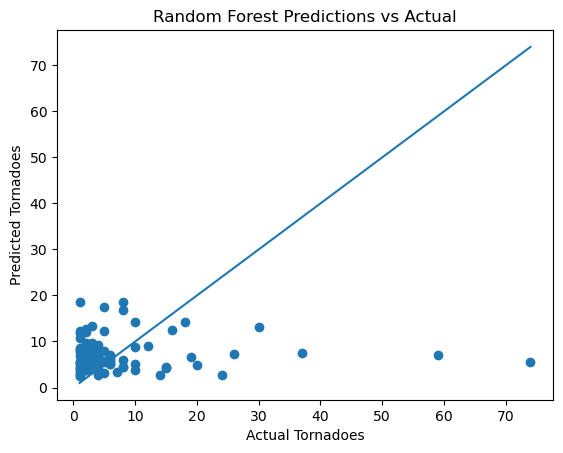

In [39]:
#Scatter plot of the predicted and observed number of tornadoes over illinois. 

plt.scatter(y_test_rf, y_pred)
plt.xlabel('Actual Tornadoes')
plt.ylabel('Predicted Tornadoes')
plt.title('Random Forest Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.show()


In [40]:
# Report the correlation coefficient and RMSE of the model.
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test_rf, y_pred))
corr = np.corrcoef(y_test_rf, y_pred)[0,1]

print(f"RMSE: {rmse:.2f}")
print(f"Correlation coefficient: {corr:.2f}")


RMSE: 10.69
Correlation coefficient: 0.05


In [41]:
#4
#Create a one-hot encoding for the month of the year.  
# Repeat the scatterplot and compare the RMSE and correlation coefficient values.

# Used the example from M6N1 but got an error. I used ChatGPT and it said I needed a list of dictionaries and not a dataframe
# Which makes senese. I see in M6N1 it also mentions when you data comes as a list of dictionaries. 

#Convert Months to a list of dictionaries
months = merged_df.index.month
month_d = [{'month': m} for m in months]


from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
one_hot = vec.fit_transform(month_d)

vec.get_feature_names_out()

# Convert NumPy array to DataFrame so can integrade with Y (tornados)
month_df = pd.DataFrame(
    one_hot,
    index=merged_df.index,        
    columns=vec.get_feature_names_out())

In [42]:
target_col = 'tor'
merged_df = merged_df.copy()
X = pd.concat([merged_df.drop(columns=[target_col]).copy(), month_df], axis=1)
y = merged_df[target_col].copy()
feature_names = X.columns.tolist()
X.shape, y.shape

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)

#Train the Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=40)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

Train size: (330, 5) Test size: (110, 5)


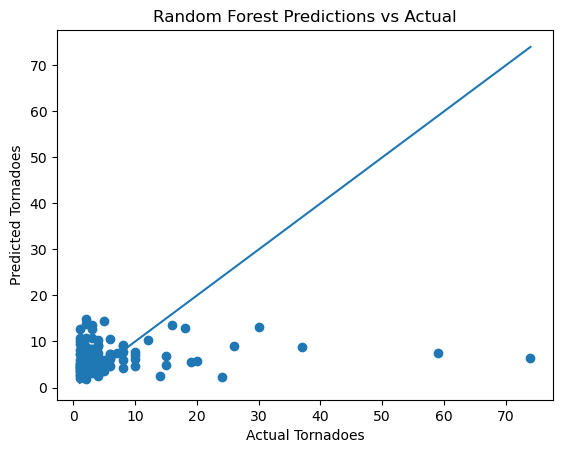

In [43]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Tornadoes')
plt.ylabel('Predicted Tornadoes')
plt.title('Random Forest Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.show()


In [44]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
corr = np.corrcoef(y_test, y_pred)[0,1]

print(f"RMSE: {rmse:.2f}")
print(f"Correlation coefficient: {corr:.2f}")

RMSE: 10.37
Correlation coefficient: 0.12


<Axes: title={'center': 'Feature Importance'}>

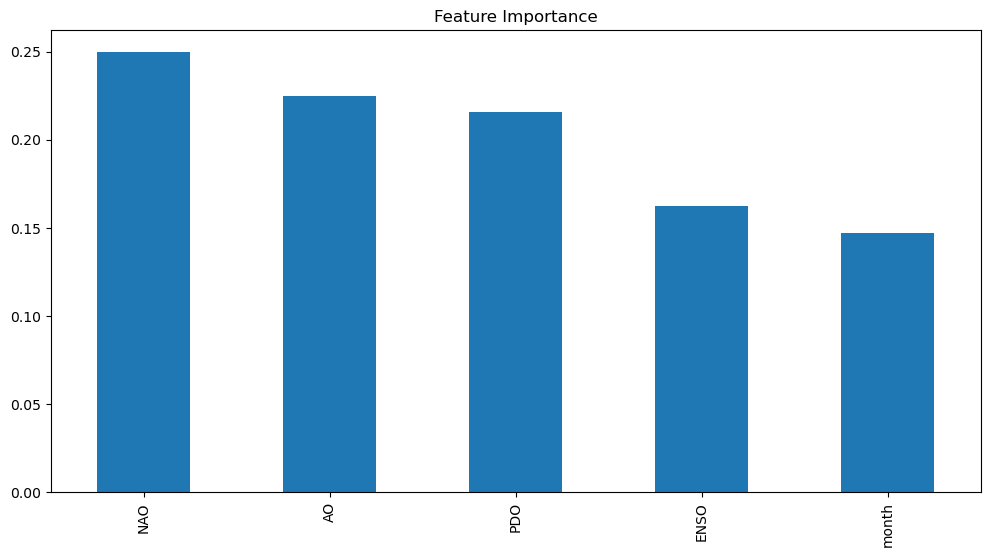

In [45]:
# 5 Perform a feature importance and multipass permutation analysis of your features.

# Feature Importance
importance = pd.Series(rf.feature_importances_)
importance.index = X.columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6), title='Feature Importance')

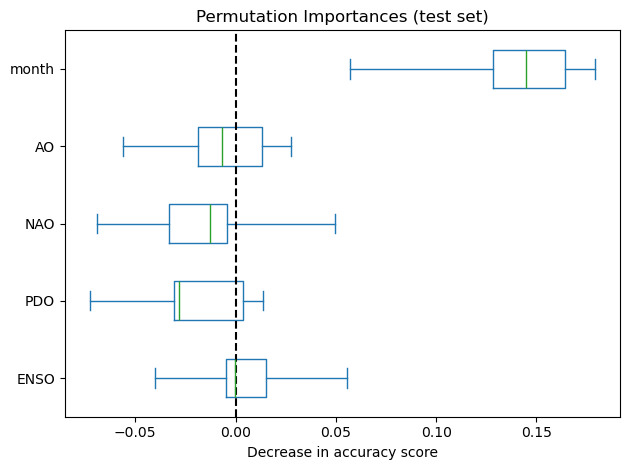

In [46]:
# Multipass Permutation

from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

importances = pd.DataFrame(
    result.importances.T.astype(float),
    columns=X.columns                     
)

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


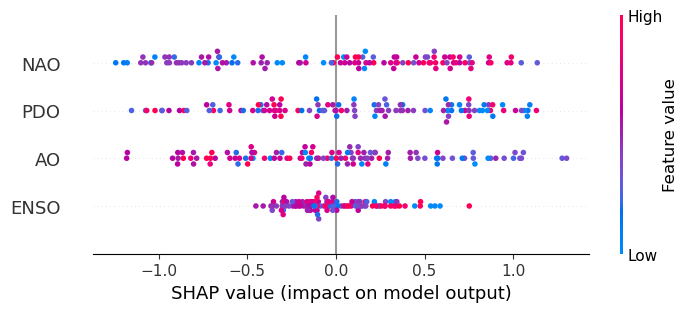

In [54]:
# 6. Create a SHAP Summary Plot showing feature importance and feature effects
from sklearn.ensemble import HistGradientBoostingClassifier
import shap

clf = HistGradientBoostingClassifier(max_depth=6, learning_rate=0.07, max_leaf_nodes=31, random_state=0)
clf.fit(X_train_rf, y_train_rf)

shap.initjs()

explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_test_rf, check_additivity=False)  # shap.Explanation

shap_values = shap_values[:, :, 1] if shap_values.values.ndim == 3 else shap_values_clf

shap.plots.beeswarm(shap_values, max_display=12)

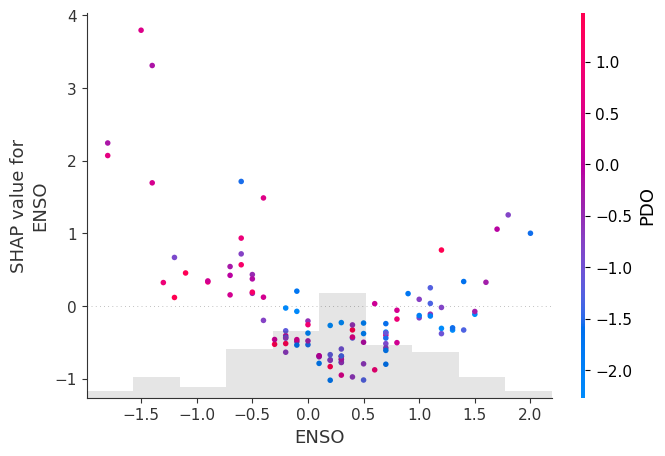

In [57]:
# 7 Create a SHAP Feature Dependence for the ENSO index.

explainer_rf = shap.TreeExplainer(rf)
shap_values = explainer_rf(X_test_rf, check_additivity=False)

shap.plots.scatter(
    shap_values[:, 'ENSO'],   # SHAP values for ENSO
    color=shap_values[:, 'PDO']
)


In [ ]:
#8 Any observations on the importance of the various features in your model from the XAI techniques you tried?

# NAO and PDO seem to be the most important due to the wide range on the SHAP summary plot. Most of the points for the 
# ENSO are negative and clustered. This may show that ENSO may decrease the number of tornadoes